# Analyse trends

The main goal here is to extract keywords used to quantify good and bad beers, for different time periods. The idea will then be to look if these words change over time, which could mean that people are not judging beers based on the same criterias anymore.

## Importing modules and custom functions

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import re # regex

from load_reviews import load_reviews

try:
    import wordcloud
except ModuleNotFoundError:
    %pip install wordcloud
    import wordcloud

try:
    import spacy
except ModuleNotFoundError:
    %pip install -U spacy
    !python -m spacy download en_core_web_sm
    import spacy
nlp = spacy.load('en_core_web_sm')

## Importing some reviews

In [32]:
reviews = load_reviews("../dataset/BeerAdvocate/reviews.txt", max_entries=100000).dropna()
display(reviews)

Loading reviews from ../dataset/BeerAdvocate/reviews.txt
Number of lines: 44022962


 39%|███▊      | 16999998/44022962 [00:10<00:17, 1548501.23it/s]


,beer_id,user_id,date,overall,rating,text
494422,97,beeradvocate.1,8.846892e+08,4.50,4.10,Presentation: It is so pleasing to obtain beer...
26272,306,beeradvocate.1,8.854668e+08,1.00,1.60,Presentation: 12oz. green bottle.Appearance: B...
999550,110,jason.3,8.859852e+08,4.50,4.33,Presentation: Pint. On tap at the Samuel Adams...
655472,2671,beeradvocate.1,8.867628e+08,4.50,4.30,Presentation: 12oz short brown twist cap bottl...
192124,44,beeradvocate.1,8.877132e+08,4.50,4.00,Presentation: Some canuks canoeing on a wild r...
...,...,...,...,...,...,...
756740,247223,milou.350022,1.501150e+09,4.25,4.39,Fantastic peach berliner weisse. Tart but not ...
940939,44568,libeertarian.948639,1.501150e+09,3.50,3.59,"From notes taken 04/19/17:Copper-amber, very h..."
650564,281131,fbarber.1116849,1.501150e+09,4.25,4.22,Pours a bright gold color. Completely clear an...
839555,155894,therougebastard.617271,1.501150e+09,4.00,4.16,Aged well...the Chai is really pronounced here...


## Extracting a list of users and their number of reviews

This will allow us to look at the most active users only.

In [33]:
dummy = reviews.groupby("user_id").count().sort_values(by="rating", ascending=False)
user_ids = dummy.index.values
user_counts = dummy["rating"].values

# Print the top 10 users
for i in range(10):
    print(f"{user_ids[i]} has {user_counts[i]} reviews")

uclabrewn84.439438 has 5086 reviews
biboergosum.168458 has 5036 reviews
sammy.3853 has 3957 reviews
phyl21ca.2335 has 3868 reviews
mactrail.311921 has 2783 reviews
kojevergas.492136 has 2550 reviews
metter98.95017 has 2495 reviews
womencantsail.222552 has 2413 reviews
blackhaddock.90923 has 2359 reviews
wordemupg.297617 has 2212 reviews


## Making some plots

In the following, we will make 4 plots, for the most active user only:
* The most used reviews for a "good beer" tested long ago
* The most used reviews for a "good beer" tested recently
* The most used reviews for a "bad beer" tested long ago
* The most used reviews for a "bad beer" tested recently

Text(0.5, 1.0, 'Poor reviews (<3.5), recent (based on 424 reviews)')

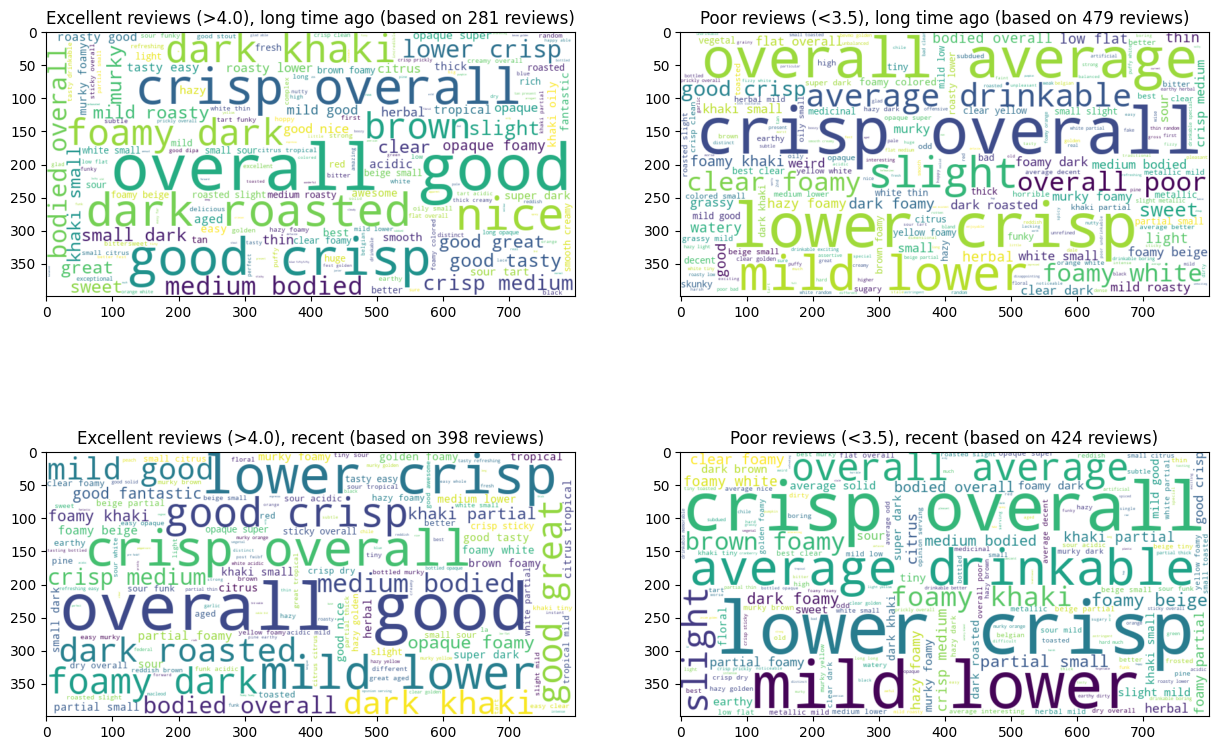

In [34]:
rating_quantiles = np.quantile(
    a=reviews.query("user_id == @user_ids[0]")["overall"].values,
    q=[0.25, 0.75]
)

date_quantiles = np.quantile(
    a=reviews.query("user_id == @user_ids[0]")["date"].values,
    q=[0.5]
)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

reviews_subset = reviews.query("user_id == @user_ids[0] & overall > @rating_quantiles[1] & date < @date_quantiles[0]").copy()
texts = " ".join(reviews_subset["text"].values).lower()
adjectives = adjectives = [str(t) for t in nlp(texts) if t.pos_ == "ADJ"]
wc = wordcloud.WordCloud(background_color="white", max_words=1000, width=800, height=400).generate(" ".join(adjectives))
axes[0, 0].imshow(wc, interpolation="bilinear")
axes[0, 0].set_title(f"Excellent reviews (>{rating_quantiles[1]}), long time ago (based on {len(reviews_subset)} reviews)")

reviews_subset = reviews.query("user_id == @user_ids[0] & overall < @rating_quantiles[0] & date < @date_quantiles[0]").copy()
texts = " ".join(reviews_subset["text"].values).lower()
adjectives = adjectives = [str(t) for t in nlp(texts) if t.pos_ == "ADJ"]
wc = wordcloud.WordCloud(background_color="white", max_words=1000, width=800, height=400).generate(" ".join(adjectives))
axes[0, 1].imshow(wc, interpolation="bilinear")
axes[0, 1].set_title(f"Poor reviews (<{rating_quantiles[0]}), long time ago (based on {len(reviews_subset)} reviews)")

reviews_subset = reviews.query("user_id == @user_ids[0] & overall > @rating_quantiles[1] & date > @date_quantiles[0]").copy()
texts = " ".join(reviews_subset["text"].values).lower()
adjectives = adjectives = [str(t) for t in nlp(texts) if t.pos_ == "ADJ"]
wc = wordcloud.WordCloud(background_color="white", max_words=1000, width=800, height=400).generate(" ".join(adjectives))
axes[1, 0].imshow(wc, interpolation="bilinear")
axes[1, 0].set_title(f"Excellent reviews (>{rating_quantiles[1]}), recent (based on {len(reviews_subset)} reviews)")

reviews_subset = reviews.query("user_id == @user_ids[0] & overall < @rating_quantiles[0] & date > @date_quantiles[0]").copy()
texts = " ".join(reviews_subset["text"].values).lower()
adjectives = adjectives = [str(t) for t in nlp(texts) if t.pos_ == "ADJ"]
wc = wordcloud.WordCloud(background_color="white", max_words=1000, width=800, height=400).generate(" ".join(adjectives))
axes[1, 1].imshow(wc, interpolation="bilinear")
axes[1, 1].set_title(f"Poor reviews (<{rating_quantiles[0]}), recent (based on {len(reviews_subset)} reviews)")

## Go further

To see if there is a real **evolution** in the trends, or if the differences among the plots above is only due to random fluctuations, we could imagine looking at the frequency of some specific words over time.

![](word_evolution_good.png)

![](word_evolution_bad.png)

In the following, we explore a little bit the words used for **good reviews**.

Between 1269601200 and 1308445920:
  Number of reviews: 31
  Frequency of 'white': 0.19 per positive review
Between 1308445920 and 1347290640:
  Number of reviews: 148
  Frequency of 'white': 0.19 per positive review
Between 1347290640 and 1386135360:
  Number of reviews: 117
  Frequency of 'white': 0.068 per positive review
Between 1386135360 and 1424980080:
  Number of reviews: 137
  Frequency of 'white': 0.26 per positive review
Between 1424980080 and 1463824800:
  Number of reviews: 244
  Frequency of 'white': 0.25 per positive review
Between 1269601200 and 1308445920:
  Number of reviews: 31
  Frequency of 'bitter': 1.1 per positive review
Between 1308445920 and 1347290640:
  Number of reviews: 148
  Frequency of 'bitter': 0.6 per positive review
Between 1347290640 and 1386135360:
  Number of reviews: 117
  Frequency of 'bitter': 0.74 per positive review
Between 1386135360 and 1424980080:
  Number of reviews: 137
  Frequency of 'bitter': 0.88 per positive review
Between 1424980080

Text(0, 0.5, 'Frequency [# / review]')

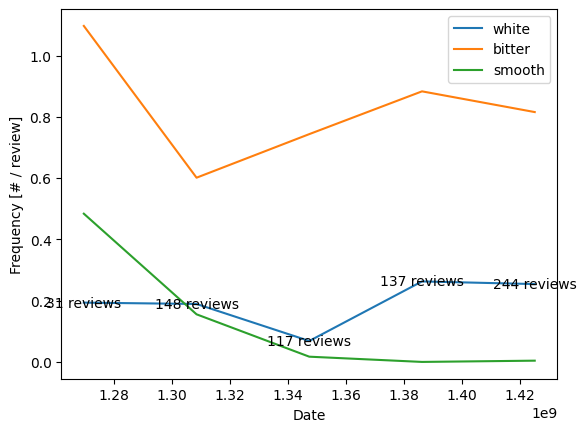

In [35]:
WORDS = ["white", "bitter", "smooth"]
BINS = 5

dates = reviews.query("user_id == @user_ids[0] & overall > @rating_quantiles[1]").copy()["date"].values
date_min = dates.min()
date_max = dates.max()
dates = np.linspace(date_min, date_max, BINS + 1)

number_of_reviewss = np.zeros(shape=(BINS, len(WORDS)))
frequencies = np.zeros(shape=(BINS, len(WORDS)))

for word_index, word in enumerate(WORDS):

    for i, (date_1, date_2) in enumerate(zip(dates[:-1], dates[1:])):
        print(f"Between {date_1:.0f} and {date_2:.0f}:")
        number_of_reviews = len(reviews.query("user_id == @user_ids[0] & overall > @rating_quantiles[1] & date > @date_1 & date < @date_2").copy()["text"].values)
        number_of_reviewss[i, word_index] = number_of_reviews
        print(f"  Number of reviews: {number_of_reviews}")
        texts = " ".join(reviews.query("user_id == @user_ids[0] & overall > @rating_quantiles[1] & date > @date_1 & date < @date_2").copy()["text"].values)
        count = len(re.findall(word, texts.lower()))
        frequency = count / number_of_reviews
        frequencies[i, word_index] = frequency
        print(f"  Frequency of '{word}': {frequency:.2} per positive review")

plt.plot(dates[:-1], frequencies[:, 0], label=WORDS[0])
plt.plot(dates[:-1], frequencies[:, 1], label=WORDS[1])
plt.plot(dates[:-1], frequencies[:, 2], label=WORDS[2])
for i, date_1 in enumerate(dates[:-1]):
    plt.text(
        x=date_1,
        y=frequencies[i, 0],
        s=f"{number_of_reviewss[i, 0]:.0f} reviews",
        horizontalalignment="center",
        verticalalignment="center"
    )
plt.legend()
plt.xlabel("Date")
plt.ylabel("Frequency [# / review]")

We should still consider uncertainties. For simplicity, we did just put the number of reviews that have been taken into consideration. Obviously, the more reviews, the small the uncertainties.